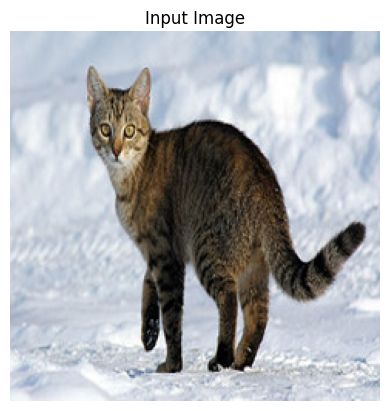

1/1 [==============================] - 9s 9s/step
1. lynx (39.07%)
2. Egyptian_cat (13.69%)
3. tiger_cat (6.70%)


In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.applications import EfficientNetB1
from tensorflow.keras.applications.efficientnet import preprocess_input, decode_predictions
from tensorflow.keras.utils import get_file
from PIL import Image
import requests
from io import BytesIO

# Load pre-trained EfficientNetB1 model
model = EfficientNetB1(weights='imagenet')

# Download a sample image (a tiger)
url = "https://storage.googleapis.com/download.tensorflow.org/example_images/320px-Felis_catus-cat_on_snow.jpg"
response = requests.get(url)
img = Image.open(BytesIO(response.content)).resize((240, 240))

# Show the image
plt.imshow(img)
plt.axis('off')
plt.title("Input Image")
plt.show()

# Preprocess for EfficientNet
img_array = np.array(img)
img_array = np.expand_dims(img_array, axis=0)  # shape (1, 240, 240, 3)
img_array = preprocess_input(img_array)

# Predict
preds = model.predict(img_array)
decoded_preds = decode_predictions(preds, top=3)[0]

# Print predictions
for i, (imagenet_id, label, confidence) in enumerate(decoded_preds):
    print(f"{i+1}. {label} ({confidence*100:.2f}%)")

In [3]:
import os
import numpy as np
from PIL import Image
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import EfficientNetB1
from tensorflow.keras.applications.efficientnet import preprocess_input

# Configuration
data_dir = r"C:\Users\dinuk\training_dataset"
class_names = ['Blocking', 'fastfading', 'gblur', 'wn', 'original']  # Folder names
img_size = (240, 240)
patch_size = (80, 80)
batch_size = 32


In [4]:
def get_patches_from_image(image_path, label_idx):
    img = Image.open(image_path).convert('RGB')
    w, h = img.size
    pw, ph = patch_size
    for y in range(0, h, ph):
        for x in range(0, w, pw):
            box = (x, y, x + pw, y + ph)
            patch = img.crop(box)
            if patch.size == patch_size:
                patch = patch.resize(img_size)
                patch_array = np.array(patch)
                yield patch_array, label_idx


In [5]:
def create_patch_dataset(root_dir):
    for label, class_name in enumerate(class_names):
        class_path = os.path.join(root_dir, class_name)
        print(f"🔍 Checking folder: {class_path}")
        if not os.path.exists(class_path):
            print(f"❌ Folder not found: {class_path}")
            continue
        image_files = [os.path.join(class_path, f) for f in os.listdir(class_path)
                       if f.lower().endswith(('png', 'jpg', 'jpeg', 'bmp'))]
        print(f"📷 Found {len(image_files)} image(s) in {class_name}")
        for img_path in image_files:
            yield from get_patches_from_image(img_path, label)


In [6]:
def prepare_tf_dataset(generator, batch_size=16):
    def gen():
        for patch, label in generator:
            yield preprocess_input(patch.astype(np.float32)), label

    output_signature = (
        tf.TensorSpec(shape=(240, 240, 3), dtype=tf.float32),
        tf.TensorSpec(shape=(), dtype=tf.int32)
    )

    dataset = tf.data.Dataset.from_generator(gen, output_signature=output_signature)
    dataset = dataset.shuffle(1000).repeat().batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return dataset



In [2]:
def build_model(num_classes):
    base_model = EfficientNetB1(include_top=False, weights='imagenet', input_shape=(240, 240, 3))
    base_model.trainable = False  # Freeze base initially

    model = models.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='softmax')
    ])

    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model


In [1]:
from sklearn.metrics import ConfusionMatrixDisplay

# Define your class names (same order as used in training)
class_names = ['Blocking', 'fastfading', 'gblur', 'wn', 'original']

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
plt.figure(figsize=(8, 6))
disp.plot(cmap='Blues', values_format='d')
plt.title("Confusion Matrix on Validation Set")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

NameError: name 'confusion_matrix' is not defined

In [11]:
print("🔄 Extracting patches for training...")
train_generator = create_patch_dataset(data_dir)
train_ds = prepare_tf_dataset(train_generator, batch_size=batch_size)

total_steps = len(list(create_patch_dataset(data_dir))) // batch_size

print("✅ Training EfficientNetB1 model on patches...")
model = build_model(num_classes=len(class_names))
model.fit(...,
    workers=1,
    use_multiprocessing=False,
    shuffle=True)
#model.fit(train_ds, epochs=20) #steps_per_epoch=total_steps)


model.save("efficientnet_patch_model.h5")
print("💾 Model saved to efficientnet_patch_model.h5")


🔄 Extracting patches for training...
🔍 Checking folder: C:\Users\dinuk\training_dataset\Blocking
📷 Found 145 image(s) in Blocking
🔍 Checking folder: C:\Users\dinuk\training_dataset\fastfading
📷 Found 145 image(s) in fastfading
🔍 Checking folder: C:\Users\dinuk\training_dataset\gblur
📷 Found 145 image(s) in gblur
🔍 Checking folder: C:\Users\dinuk\training_dataset\wn
📷 Found 140 image(s) in wn
🔍 Checking folder: C:\Users\dinuk\training_dataset\original
📷 Found 29 image(s) in original
✅ Training EfficientNetB1 model on patches...


ValueError: Failed to find data adapter that can handle input: <class 'ellipsis'>, <class 'NoneType'>